# Task 1.2 - Linear classifier

In this task, we will implement another machine learning model - a linear classifier. The linear classifier selects weights for each class, by which the value of each attribute must be multiplied and then added together.
The class for which this sum is greater is the prediction of the model.

In this assignment, you:
- practice calculating gradients of various multidimensional functions
- implement the calculation of gradients through the linear model and the softmax loss function
- implement the process of training a linear classifier
- select training parameters in practice

Just in case, once again the link to the numpy tutorial:
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# As always, the first thing to do is load the data

We will use the same SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Play with gradients!

In this course, we will write many functions that calculate gradients analytically.

All functions in which we will calculate gradients will be written according to the same scheme.
They will receive at the input the point where the value and the gradient of the function need to be calculated, and at the output they will produce a tuple of two values ​​- the actual value of the function at this point (always one number) and the analytical value of the gradient at the same point (the same dimension as the input).
``,
def f (x):
    "" "
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function
    grad: np array of float, same shape as x
    "" "
    ...
    
    return value, grad
``,

A necessary tool during the implementation of code that calculates gradients is the function of its validation. This function computes the gradient numerically and compares the result with the analytically computed gradient.

We start by implementing the numeric gradient computation in the check_gradient function in gradient_check.py. This function will take as input to the function of the format specified above, use the value `value` to calculate the numerical gradient and compare it with the analytical one - they should converge.

Write a part of a function that calculates the gradient using the numerical derivative for each coordinate. To calculate the derivative, use the so-called two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

All functions shown in the next cell must pass the gradient check.

In [19]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Let's start writing our functions that calculate the analytical gradient

Now let's implement the softmax function, which receives the estimates for each class as input and converts them into probabilities from 0 to 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

** Important: ** The practical aspect of calculating this function is that it calculates the exponent of potentially very large numbers - this can lead to very large values ​​in the numerator and denominator outside the float range.

Fortunately, there is a simple solution to this problem - before calculating the softmax, subtract from all estimates the maximum value among all estimates:
``,
predictions - = np.max (predictions)
``,
(more details here - http://cs231n.github.io/linear-classify/#softmax, section `Practical issues: Numeric stability`)

In [21]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

In addition, we will implement a cross-entropy loss, which we will use as an error function.
In general, cross-entropy is defined as follows:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

where x are all classes, p (x) is the true probability of the sample belonging to the class x, and q (x) is the probability of belonging to the class x, as predicted by the model.
In our case, the sample belongs to only one class, the index of which is passed to the function. For it, p (x) is equal to 1, and for the rest of the classes - 0.

This makes the function easier to implement!

In [23]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

After we have implemented the functions themselves, we can implement the gradient.

It turns out that calculating the gradient becomes much easier if you combine these functions into one, which first calculates the probabilities through softmax, and then uses them to calculate the error function through cross-entropy loss.

This softmax_with_cross_entropy function will return both the error value and the gradient across the input parameters. We will check the correctness of the implementation with `check_gradient`.

In [ ]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

As a training method, we will use stochastic gradient descent (SGD), which works with sample batches.

Therefore, all our functions will receive not one example, but a batch, that is, the input will not be a vector from `num_classes` evaluations, but a matrix of dimensions` batch_size, num_classes`. The index of the example in the batch will always be the first dimension.

The next step is to rewrite our functions to support batches.

The final value of the error function must remain a number, and it is equal to the average error value among all examples in the batch.

In [24]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Finally, let's implement the linear classifier itself!

softmax and cross-entropy receive estimates as input, which are given by the linear classifier.

He makes it very simple: for each class there is a set of weights by which the pixels of the picture must be multiplied and added. The resulting number is the class estimate that goes to the softmax input.

Thus, a linear classifier can be represented as the multiplication of a vector with pixels by a matrix W of size `num_features, num_classes`. This approach can be easily extended to the case of batch vectors with X pixels of size `batch_size, num_features`:

`predictions = X * W`, where` * `is matrix multiplication.

Implement the `linear_softmax` function for calculating the linear classifier and weighted gradients in the file` linear_classifer.py`

In [25]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### And now regularization

We will use L2 regularization for the weights as part of the overall error function.

Recall that L2 regularization is defined as

l2_reg_loss = regularization_strength * sum <sub> ij </sub> W [i, j] <sup> 2 </sup>

Implement a function to compute it and compute the appropriate gradients.

In [38]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Workout!

The gradients are in order, let's implement the training process!

In [39]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1, verbose=1)

Epoch 0, loss: 691.077785
Epoch 1, loss: 712.749169
Epoch 2, loss: 721.845799
Epoch 3, loss: 715.038916
Epoch 4, loss: 710.684216
Epoch 5, loss: 772.027078
Epoch 6, loss: 865.797149
Epoch 7, loss: 878.524957
Epoch 8, loss: 895.171605
Epoch 9, loss: 883.155392


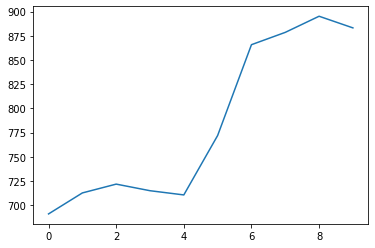

In [40]:
# let's look at the loss history!
plt.plot(loss_history)

In [41]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1, verbose=1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.144
Epoch 0, loss: 928.421367
Epoch 1, loss: 892.918940
Epoch 2, loss: 779.946284
Epoch 3, loss: 748.959377
Epoch 4, loss: 721.792371
Epoch 5, loss: 749.993731
Epoch 6, loss: 808.052565
Epoch 7, loss: 893.858597
Epoch 8, loss: 761.667346
Epoch 9, loss: 732.110171
Epoch 10, loss: 764.896584
Epoch 11, loss: 822.292666
Epoch 12, loss: 837.657406
Epoch 13, loss: 794.137673
Epoch 14, loss: 762.657260
Epoch 15, loss: 799.105739
Epoch 16, loss: 821.750112
Epoch 17, loss: 834.937665
Epoch 18, loss: 961.965250
Epoch 19, loss: 1057.538373
Epoch 20, loss: 993.176711
Epoch 21, loss: 845.210360
Epoch 22, loss: 933.403822
Epoch 23, loss: 954.427109
Epoch 24, loss: 974.960416
Epoch 25, loss: 879.816303
Epoch 26, loss: 817.673254
Epoch 27, loss: 772.010485
Epoch 28, loss: 846.289280
Epoch 29, loss: 918.485491
Epoch 30, loss: 956.307776
Epoch 31, loss: 1048.972222
Epoch 32, loss: 830.680057
Epoch 33, loss: 847.645747
Epoch 34, loss: 898.785442
Epoch 35, loss: 908.266541
Epoch 36, loss: 106

### As before, we use cross-validation to find hyperparameters.

This time, we will only use one division of training and validation data to keep the training time reasonable.

Now we need to select not one, but two hyperparameters! Don't limit yourself to the original values in the code.
Achieve more than ** 20% ** accuracy on validation data.

In [43]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0.0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for learning_rate in learning_rates:
    for reg in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs,
                       learning_rate=learning_rate, batch_size=batch_size, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier        

print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.227000


# What accuracy did we achieve on the test data?

In [44]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.176000
